# Customer Personality Analysis

In [1]:
# Need to perform clustering to summarize customer segments.
#
# The Company can analyze which customer segment is most likely 
# to buy the product and then market the product only on that particular segment.

In [ ]:
# Проект построен следующим образом.
# Сначала определяются ф-ции, для последующего запуска генетического алгоритма по подбору оптимальных
# гиперпараметров для модели регрессии XGBoost (градиентного бустинга)
# 1. Data Parsing - обработка сырых данных (оптимизация признаков, трансформация, очистка)
# 2. Проведение кластеризации пользователей 
# 2.1 Определение метрики качества - силуэтного анализа
# 2.2 Стандартизация признаков
# 2.3 Кластеризация методом KNN: итоговое разбиение на 6 сегментов
# 2.4 Кластеризация методом Mini-Batch K-means: итоговое разбиение на 4 сегмента
# 2.5 Кластеризация методом Affinity Propagation: результат неудовлетворительный
# 2.6 Кластеризация методом Агломеративной иерархической кластеризации: результат хуже, чем в 2.3 и 2.4

# В итоге разбиение на 4 сегмента методом KNN, либо на 6 сегментов методом Mini-Batch K-means 
# показывают наилучший результат
# Дальнейший анализ этих двух разбиений (статистика пользователей каждого сегмента) должен быть проведен для выбора
# оптимального разбиения

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

from sklearn.svm import SVR

import warnings

%matplotlib inline

In [ ]:
####### People
#ID: Customer's unique identifier
#Year_Birth: Customer's birth year
#Education: Customer's education level
#Marital_Status: Customer's marital status
#Income: Customer's yearly household income
#Kidhome: Number of children in customer's household
#Teenhome: Number of teenagers in customer's household
#Dt_Customer: Date of customer's enrollment with the company
#Recency: Number of days since customer's last purchase
#Complain: 1 if the customer complained in the last 2 years, 0 otherwise

####### Products
#MntWines: Amount spent on wine in last 2 years
#MntFruits: Amount spent on fruits in last 2 years
#MntMeatProducts: Amount spent on meat in last 2 years
#MntFishProducts: Amount spent on fish in last 2 years
#MntSweetProducts: Amount spent on sweets in last 2 years
#MntGoldProds: Amount spent on gold in last 2 years

####### Promotion
#NumDealsPurchases: Number of purchases made with a discount
#AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
#AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
#AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
#AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
#AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
#Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

####### Place
#NumWebPurchases: Number of purchases made through the company’s website
#NumCatalogPurchases: Number of purchases made using a catalogue
#NumStorePurchases: Number of purchases made directly in stores
#NumWebVisitsMonth: Number of visits to company’s website in the last month

In [84]:
df = pd.read_csv('Data/marketing_campaign.csv', sep='\t', skipinitialspace=True)

In [7]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# 1. Data Parsing

In [10]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

### 1.1 Переводим столбец "Dt_Customer" во время, в течении которого пользователь с компанией

In [85]:
# сначала переводим столбец в формат datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'],format='%d-%m-%Y')

In [86]:
# теперь рассчитываем время присутствия пользователя на сайте в месяцах
max_date = datetime(2014, 10, 4)
df['presence'] = df.apply(lambda x: (max_date - x['Dt_Customer']).days/30.0, axis = 1)

### 1.2 Оптимизируем признаки

###### 1.2.1 Education

In [88]:
df['Education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [89]:
df['Education'] = df['Education'].replace({'Basic':'Undergraduate','2n Cycle':'Undergraduate','Graduation':'Postgraduate','Master':'Postgraduate'})

In [91]:
df['Education'].unique()

array(['Postgraduate', 'PhD', 'Undergraduate'], dtype=object)

###### 1.2.2 Marital_Status

In [44]:
df['Marital_Status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [28]:
#widow - вдова
#yolo = absurd
#together = married
#alone = single

In [92]:
df['Marital_Status'] = df['Marital_Status'].replace({'Divorced':'Alone','Single':'Alone','Married':'Together','Absurd':'Alone','Widow':'Alone','YOLO':'Alone'})

In [94]:
df['Marital_Status'].unique()

array(['Alone', 'Together'], dtype=object)

###### 1.2.3 Year_Birth

In [97]:
# c возрастом работать удобнее, чем с годом рождения
df['Age'] = 2014 - df['Year_Birth']

###### 1.2.4 Keedhome & Teenhome

In [105]:
# Посчитаем общее кол-во детей
df['Children'] = df['Kidhome'] + df['Teenhome']

###### 1.2.5 MntWines & MntFruits & MntMeatProducts & MntFishProducts & MntSweetProducts & MntGoldProds

In [104]:
df['Spending']=df['MntWines']+df['MntFruits']+df['MntMeatProducts']+df['MntFishProducts']+df['MntSweetProducts']+df['MntGoldProds']

###### 1.2.6 Переименуем некоторые столбцы для простоты

In [107]:
df = df.rename(columns={'MntWines': "Wines",'MntFruits':'Fruits','MntMeatProducts':'Meat','MntFishProducts':'Fish','MntSweetProducts':'Sweets','MntGoldProds':'Gold'})

###### Оставляем только выборочные признаки для последующего анализа

In [114]:
data=df[['Age','Education','Marital_Status','Income','Spending','presence','Children']]

In [115]:
data.head()

,Age,Education,Marital_Status,Income,Spending,presence,Children
0,57,Postgraduate,Alone,58138.0,1617,25.333333,0
1,60,Postgraduate,Alone,46344.0,27,7.000000,2
2,49,Postgraduate,Together,71613.0,776,13.633333,0
3,30,Postgraduate,Together,26646.0,53,7.866667,1
4,33,PhD,Together,58293.0,422,8.600000,1


### 1.3 Убираем отсутствующие значения и выбросы

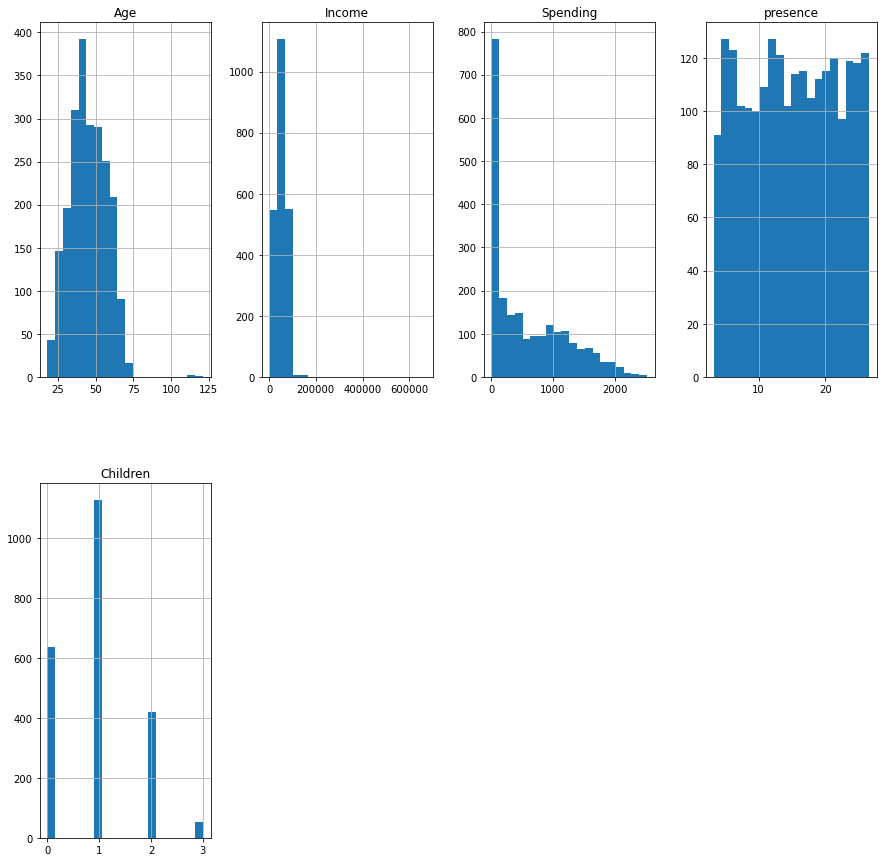

In [117]:
# Сначала посмотрим на статистику
data.hist(bins=20, figsize=(15,15),layout=(2,4));

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             2240 non-null   int64  
 1   Education       2240 non-null   object 
 2   Marital_Status  2240 non-null   object 
 3   Income          2216 non-null   float64
 4   Spending        2240 non-null   int64  
 5   presence        2240 non-null   float64
 6   Children        2240 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 122.6+ KB


In [83]:
# Параметр Income очень важен, и именно в нём есть несуществующие значения и выбросы
# Удаляем все такие строки, где Income либо выброс, либо отсутствует

In [119]:
data = data.dropna(subset=['Income'])
data = data[data['Income'] < 600000]

In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2215 entries, 0 to 2239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             2215 non-null   int64  
 1   Education       2215 non-null   object 
 2   Marital_Status  2215 non-null   object 
 3   Income          2215 non-null   float64
 4   Spending        2215 non-null   int64  
 5   presence        2215 non-null   float64
 6   Children        2215 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 138.4+ KB


### 1.4 Преобразуем нечисловые признаки Education и Marital_Status в набор числовых

In [122]:
list(data['Education'].unique())

['Postgraduate', 'PhD', 'Undergraduate']

In [128]:
# ф-ции для создания новых признаков-образования
def Edu1(education):
    if education == 'Postgraduate':
        return 1
    else:
        return 0
def Edu2(education):
    if education == 'PhD':
        return 1
    else:
        return 0
def Edu3(education):
    if education == 'Undergraduate':
        return 1
    else:
        return 0

In [126]:
data['PostGr'] = data.apply(lambda x: Edu1(x['Education']), axis = 1)
data['PhD'] = data.apply(lambda x: Edu2(x['Education']), axis = 1)
data['UnderGr'] = data.apply(lambda x: Edu3(x['Education']), axis = 1)

In [123]:
list(data['Marital_Status'].unique())

['Alone', 'Together']

In [140]:
# ф-ции для создания новых признаков-семейного статуса
def Mar1(status):
    if status == 'Alone':
        return 1
    else:
        return 0
def Mar2(status):
    if status == 'Together':
        return 1
    else:
        return 0

In [141]:
data['Alone'] = data.apply(lambda x: Mar1(x['Marital_Status']), axis = 1)
data['Together'] = data.apply(lambda x: Mar2(x['Marital_Status']), axis = 1)

### 1.5 Оставляем признаки для последующей кластеризации

In [147]:
data_a = data[['Age','Income','Spending','presence','Children','PostGr','PhD','UnderGr','Alone','Together']]

In [148]:
data_a

,Age,Income,Spending,presence,Children,PostGr,PhD,UnderGr,Alone,Together
0,57,58138.0,1617,25.333333,0,1,0,0,1,0
1,60,46344.0,27,7.000000,2,1,0,0,1,0
2,49,71613.0,776,13.633333,0,1,0,0,0,1
3,30,26646.0,53,7.866667,1,1,0,0,0,1
4,33,58293.0,422,8.600000,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2235,47,61223.0,1341,15.933333,1,1,0,0,0,1
2236,68,64014.0,444,3.866667,3,0,1,0,0,1
2237,33,56981.0,1241,8.400000,0,1,0,0,1,0
2238,58,69245.0,843,8.433333,1,1,0,0,0,1


### 2. Кластеризация

In [ ]:
# Основная задача заключается в оценке оптимального количества числа кластеров.

# Будем проводить оценку с помощью силуэтного анализа

# Суть анализа заключается в расчет пространственного расстояния между кластерами. 
# Итоговый силуэтный график отображает близость каждой точки одного кластера с точками 
# соседних кластеров и обеспечивает,таким образом, визуальный способ оценки кол-ва кластеров. 
# Итоговая мера имеет диапазон [-1, 1].

# Коэффициенты силуэта вблизи +1 показывают, что точка далеко от соседних кластеров, 
# 0 - точка на границе или рядом с соседним кластером и отрицательные значения показывают отношение точки не к тому классу.

# Также по ширине силуэтов кластеров на графике можно визуализировать размер кластера.

###### 2.1 Определение метрики качества кластеризации

In [154]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [152]:
def sil_plot(model, data, n_clusters):
    result = model.fit_predict(data)
    sil = silhouette_samples(data, result)
    silhouette_avg = silhouette_score(data, result)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :{:.3f}".format(silhouette_avg))
    y_lower = 10

    fig, ax = plt.subplots()
    fig.set_size_inches(18, 7)

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.2, 1]
    ax.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sil[result == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)

        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    plt.suptitle(("Silhouette analysis for clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

###### 2.2 Стандартизация признаков

In [178]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data_a), columns = data_a.columns, index = data_a.index)
scaled_data.head()

,Age,Income,Spending,presence,Children,PostGr,PhD,UnderGr,Alone,Together
0,0.986016,0.286604,1.675011,1.528882,-1.264487,0.704714,-0.526681,-0.359897,1.348357,-1.348357
1,1.236344,-0.261407,-0.962727,-1.188066,1.405522,0.704714,-0.526681,-0.359897,1.348357,-1.348357
2,0.318476,0.912723,0.279830,-0.205025,-1.264487,0.704714,-0.526681,-0.359897,-0.741643,0.741643
3,-1.266933,-1.176680,-0.919594,-1.059629,0.070517,0.704714,-0.526681,-0.359897,-0.741643,0.741643
4,-1.016605,0.293806,-0.307440,-0.950951,0.070517,-1.419016,1.898681,-0.359897,-0.741643,0.741643


###### 2.3 Метод KNN

For n_clusters = 3 The average silhouette_score is :0.253
For n_clusters = 4 The average silhouette_score is :0.237
For n_clusters = 5 The average silhouette_score is :0.251
For n_clusters = 6 The average silhouette_score is :0.280
For n_clusters = 7 The average silhouette_score is :0.285
For n_clusters = 8 The average silhouette_score is :0.287
For n_clusters = 9 The average silhouette_score is :0.255
For n_clusters = 10 The average silhouette_score is :0.265
For n_clusters = 11 The average silhouette_score is :0.259
For n_clusters = 12 The average silhouette_score is :0.262
For n_clusters = 13 The average silhouette_score is :0.241
For n_clusters = 14 The average silhouette_score is :0.244
For n_clusters = 15 The average silhouette_score is :0.243


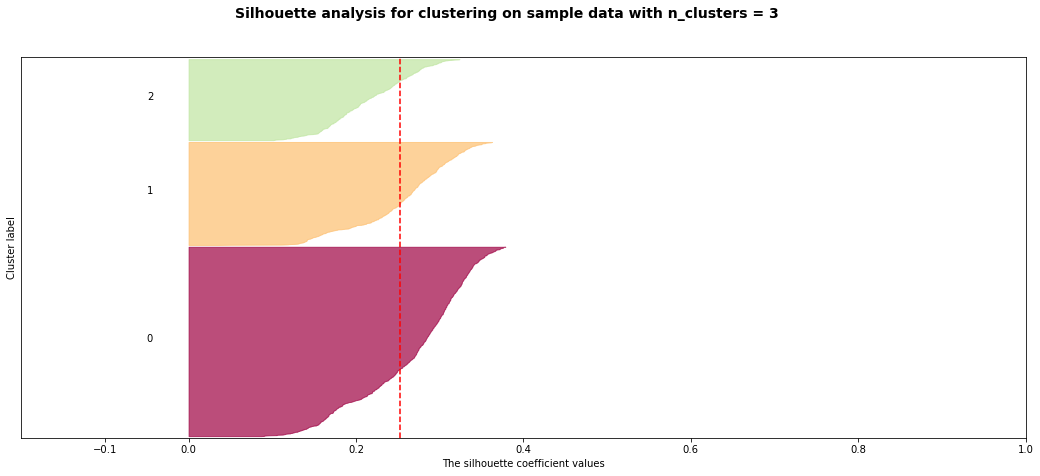

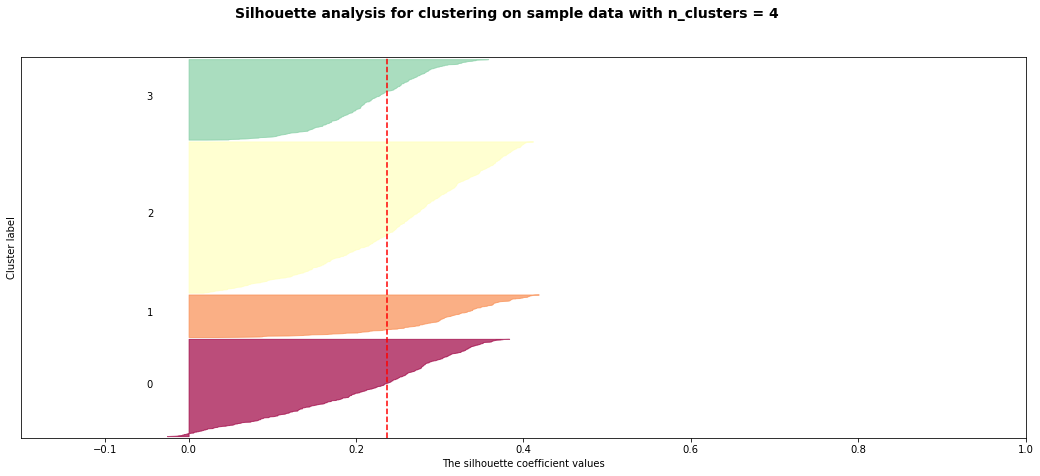

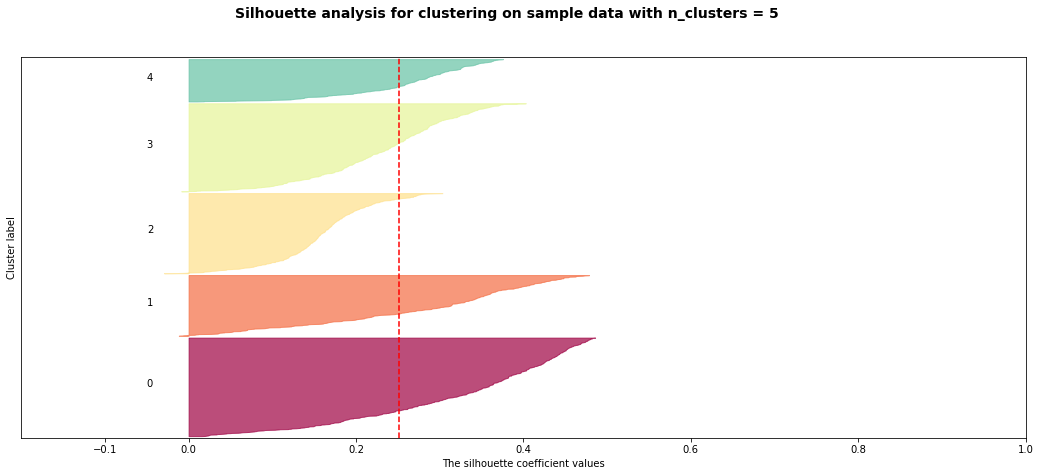

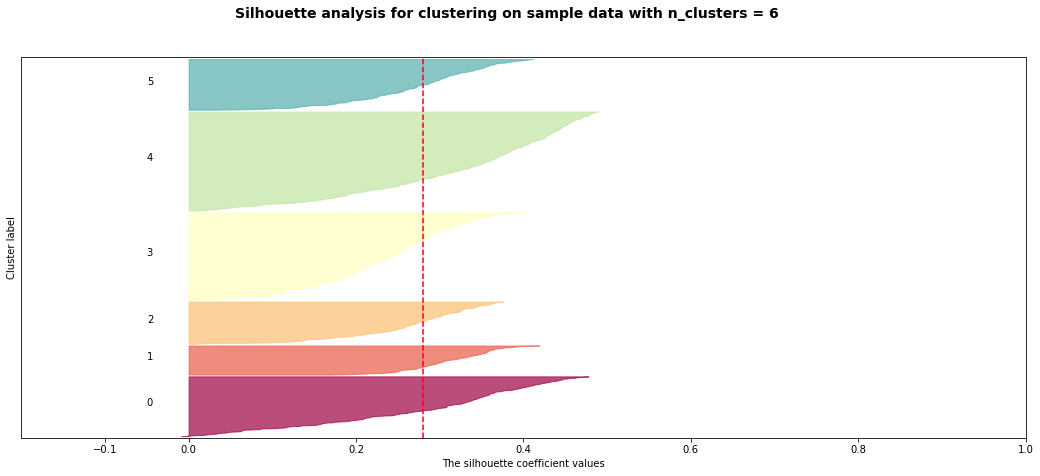

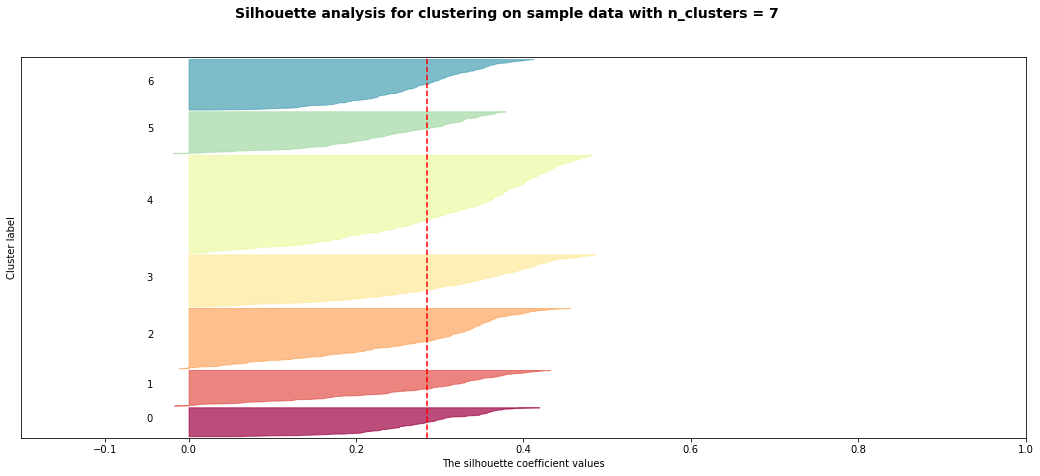

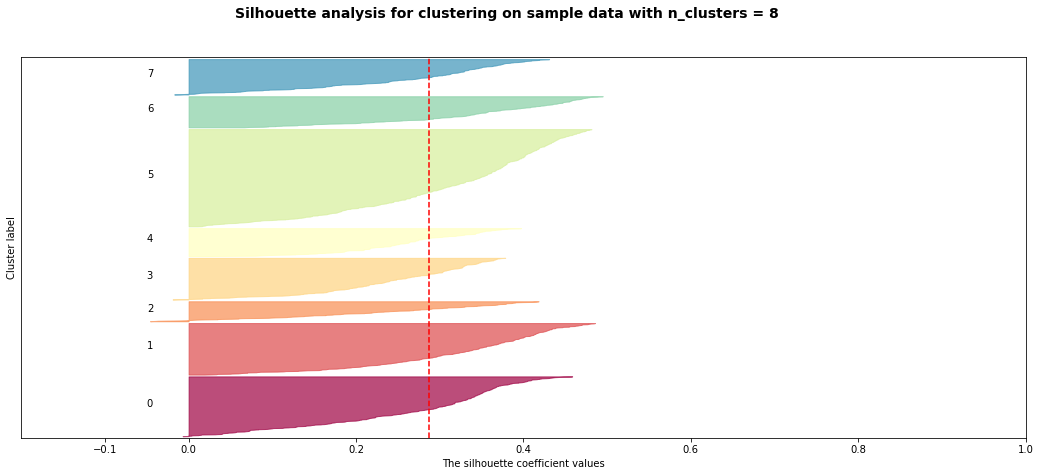

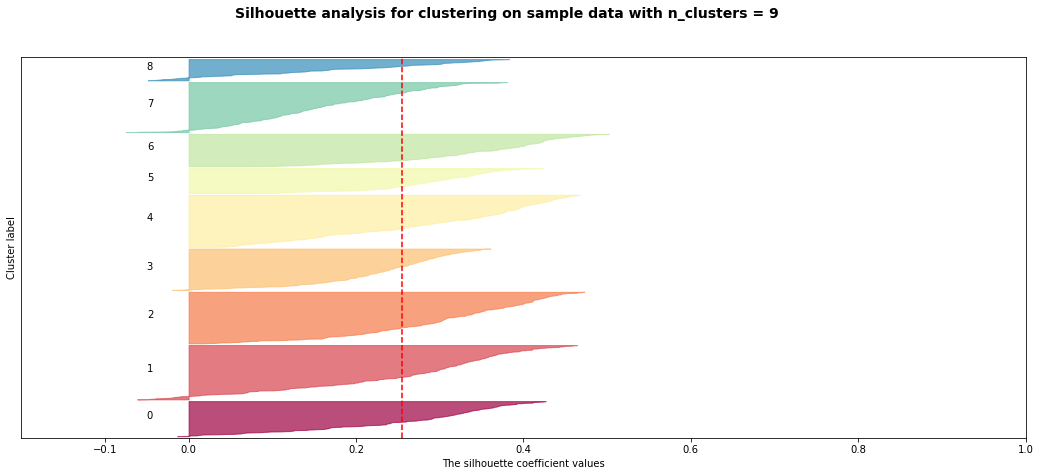

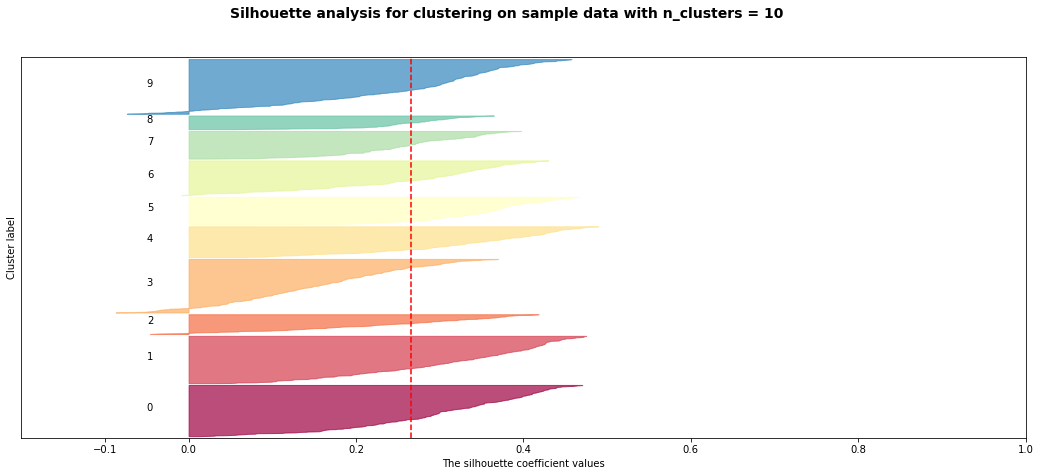

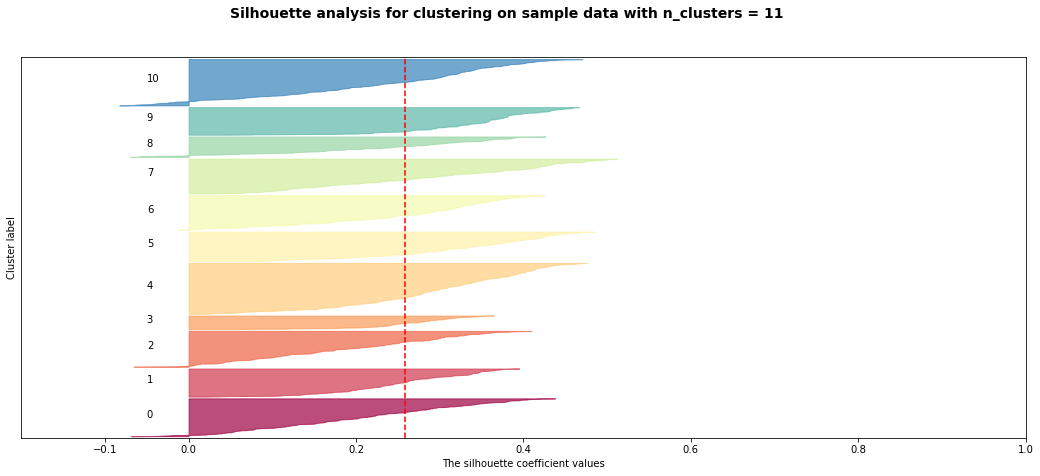

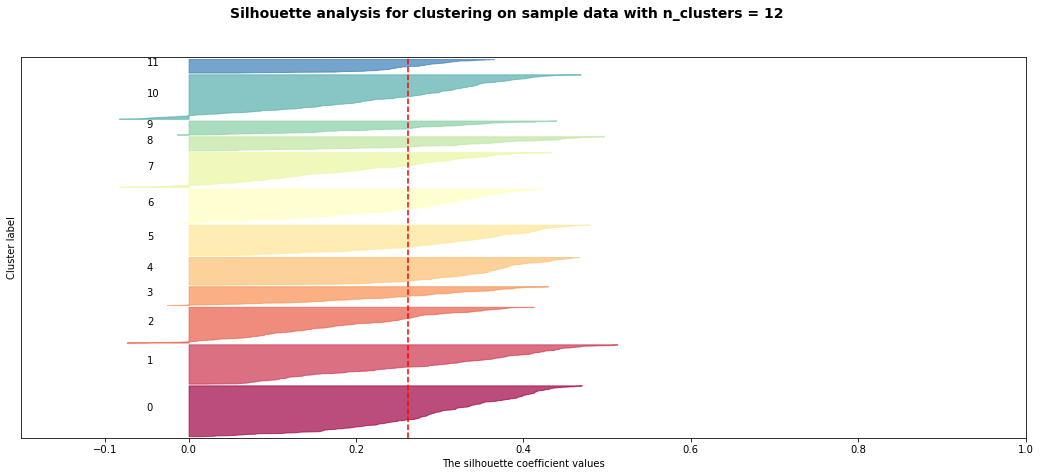

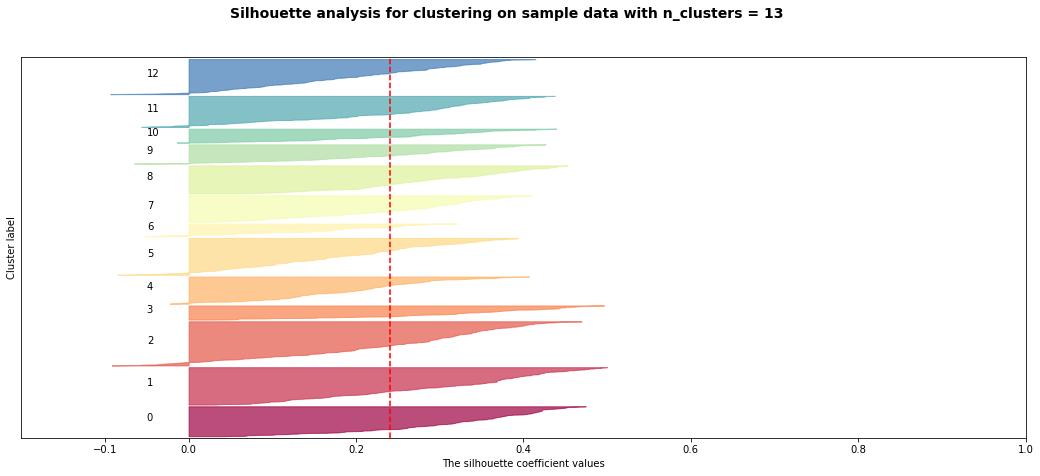

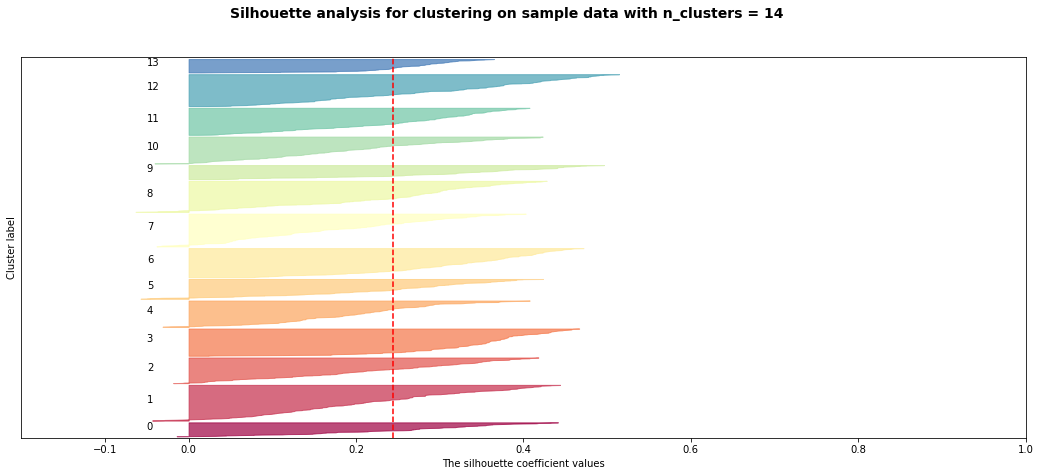

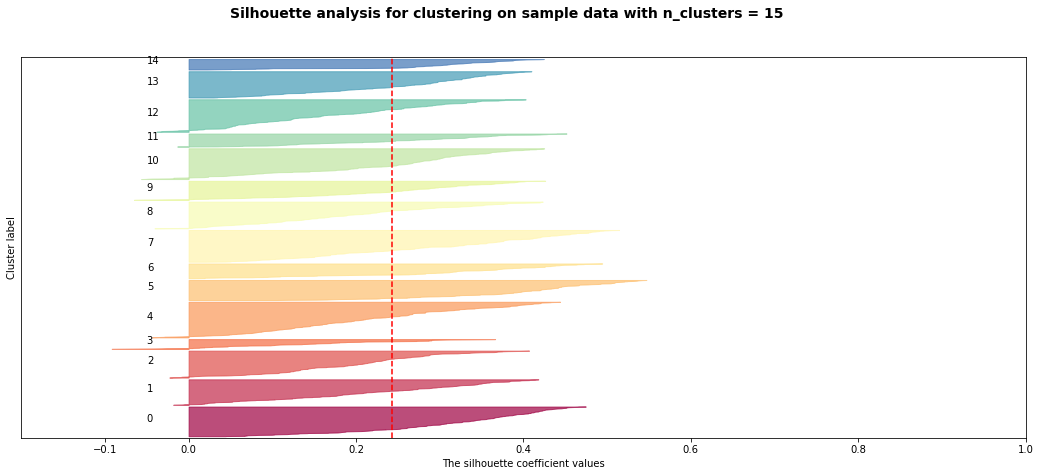

In [179]:
# попробуем пройтись по кол-ву кластеров от 3 до 15, оценивая результат по силуэтам
for n in range(3,16):
    KMN = KMeans(n_clusters=n, random_state=1)
    sil_plot(KMN, scaled_data, n)

In [180]:
# Визуально наилучшая картинка при разбиении на 3 и 6 кластеров
# При этом, средний коэффициент силуэта больший при 6 кластерах, остановимся на этом разбиении

KNM = KMeans(n_clusters=6, random_state=1)
resultKNM = KNM.fit_predict(scaled_data)
# кол-во пользователей в каждом кластере при разбиении на 6 кластеров
np.unique(resultKNM, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([360, 175, 254, 526, 595, 305], dtype=int64))

In [182]:
print("в первом сегменте средние затраты: {:.0f}".format(data_a.loc[scaled_data.index[resultKNM == 0]].Spending.mean()))
print("во втором сегменте средние затраты: {:.0f}".format(data_a.loc[scaled_data.index[resultKNM == 1]].Spending.mean()))
print("в третьем сегменте средние затраты: {:.0f}".format(data_a.loc[scaled_data.index[resultKNM == 2]].Spending.mean()))
print("в четвертом сегменте средние затраты: {:.0f}".format(data_a.loc[scaled_data.index[resultKNM == 3]].Spending.mean()))
print("в пятом сегменте средние затраты: {:.0f}".format(data_a.loc[scaled_data.index[resultKNM == 4]].Spending.mean()))
print("в шестом сегменте средние затраты: {:.0f}".format(data_a.loc[scaled_data.index[resultKNM == 5]].Spending.mean()))

в первом сегменте средние затраты: 1271
во втором сегменте средние затраты: 646
в третьем сегменте средние затраты: 407
в четвертом сегменте средние затраты: 636
в пятом сегменте средние затраты: 211
в шестом сегменте средние затраты: 691


In [183]:
# Первый сегмент представляет наибольший интерес, поскольку средние затраты покупателей значительно выше, чем в других

###### 2.4 Метод Mini-Batch K-means

In [175]:
from sklearn.cluster import KMeans, MiniBatchKMeans, AffinityPropagation

For n_clusters = 3 The average silhouette_score is :0.259
For n_clusters = 4 The average silhouette_score is :0.287
For n_clusters = 5 The average silhouette_score is :0.252
For n_clusters = 6 The average silhouette_score is :0.257
For n_clusters = 7 The average silhouette_score is :0.265
For n_clusters = 8 The average silhouette_score is :0.246
For n_clusters = 9 The average silhouette_score is :0.238
For n_clusters = 10 The average silhouette_score is :0.233
For n_clusters = 11 The average silhouette_score is :0.225
For n_clusters = 12 The average silhouette_score is :0.241
For n_clusters = 13 The average silhouette_score is :0.242
For n_clusters = 14 The average silhouette_score is :0.245
For n_clusters = 15 The average silhouette_score is :0.207


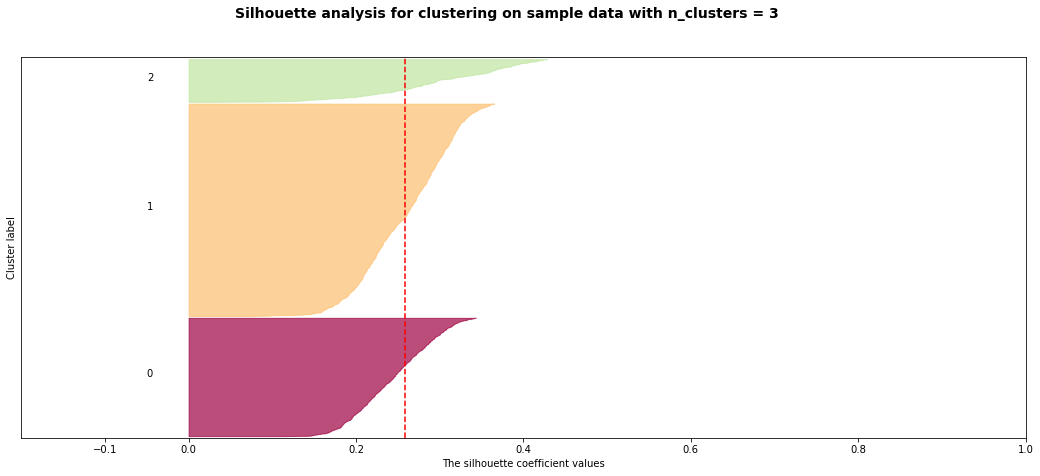

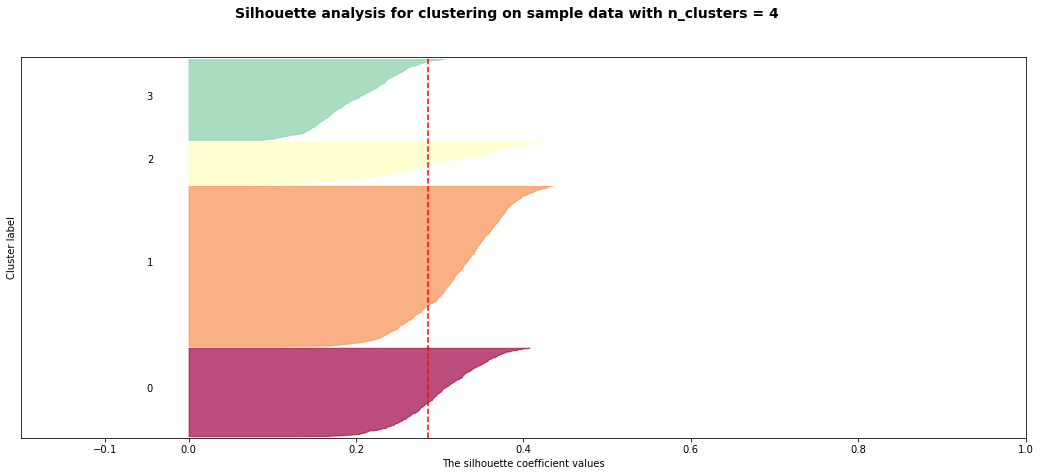

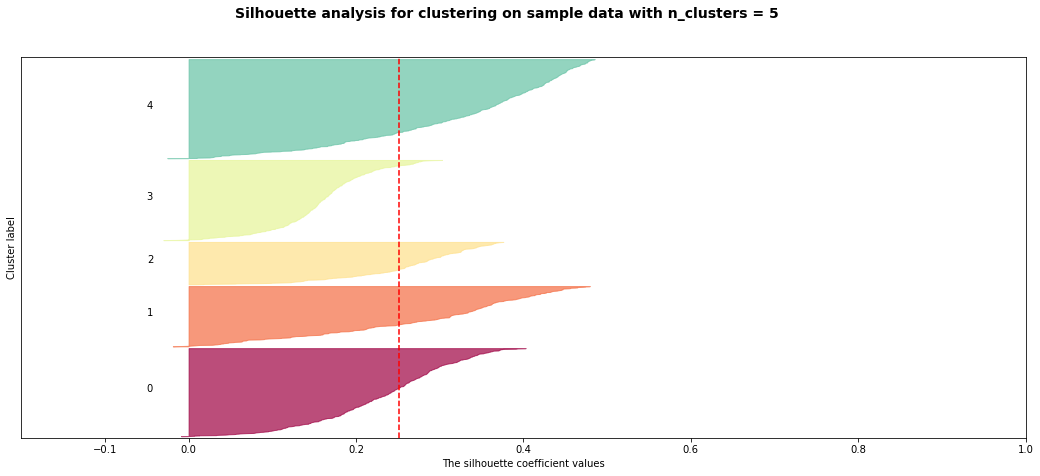

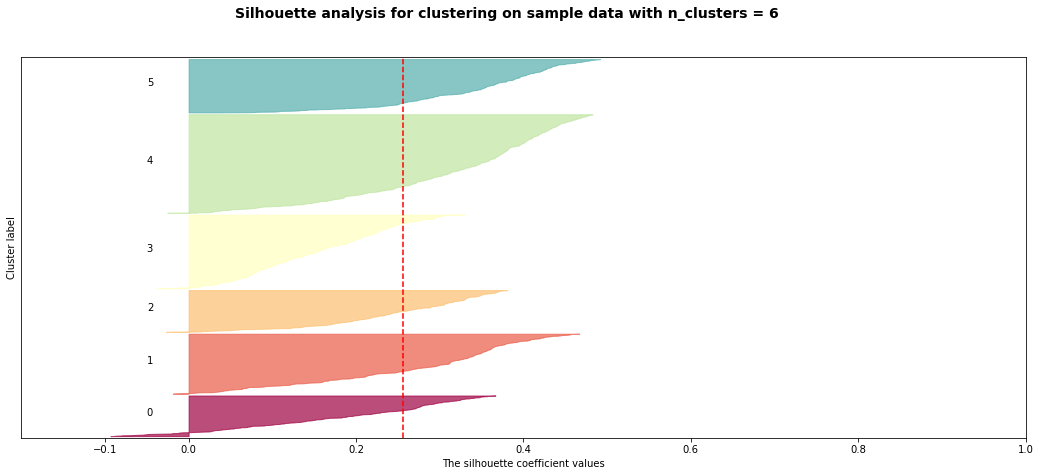

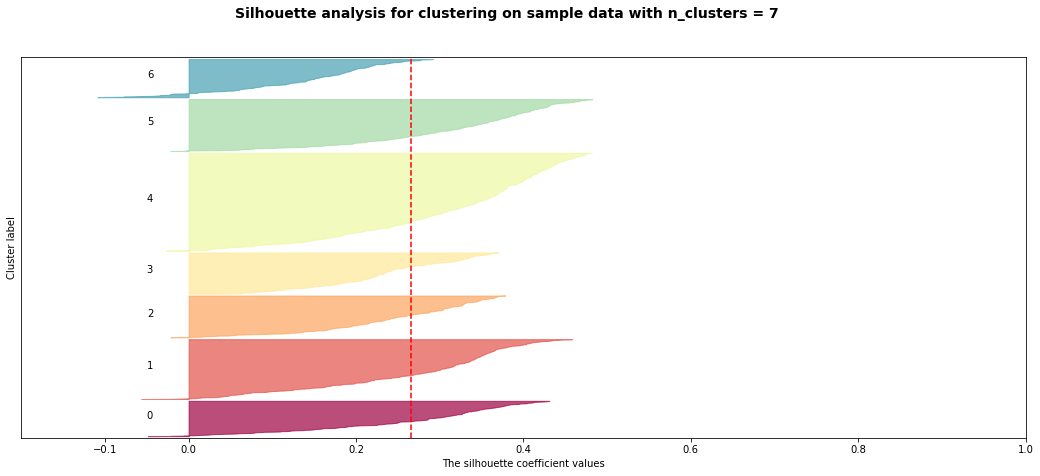

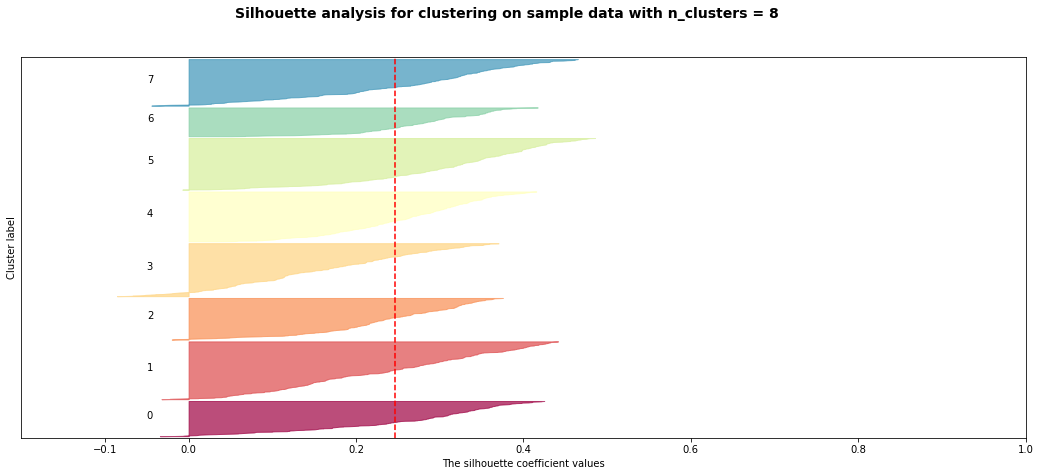

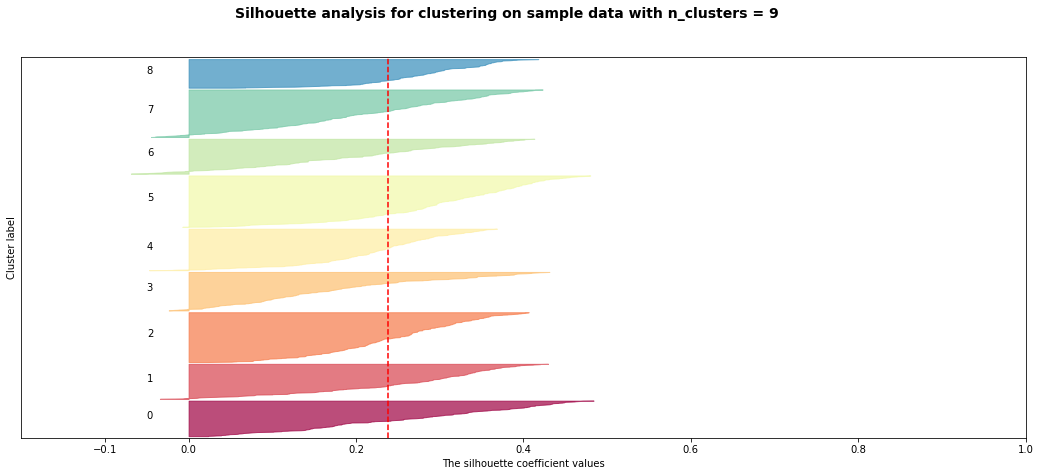

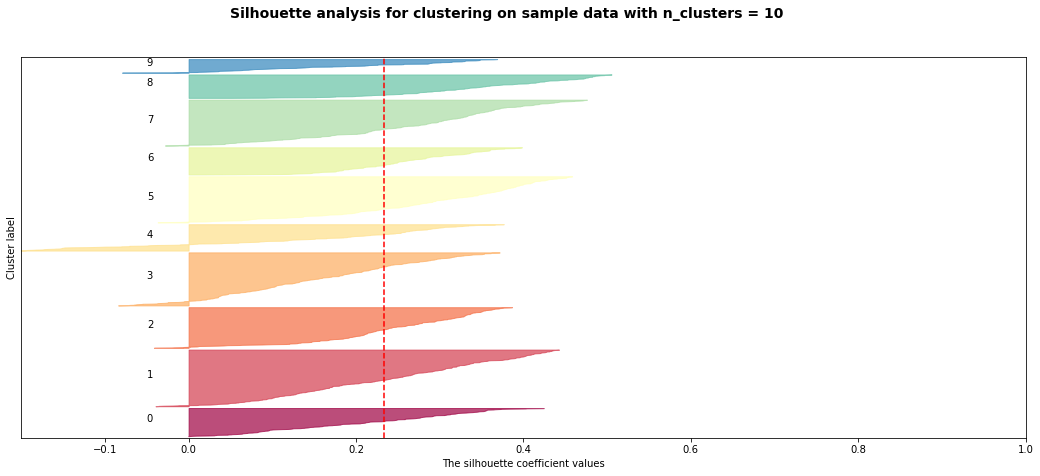

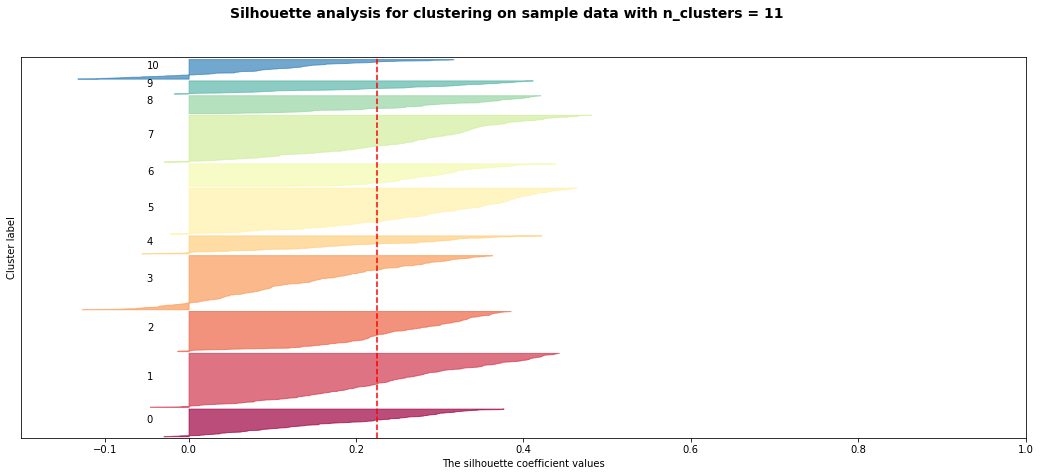

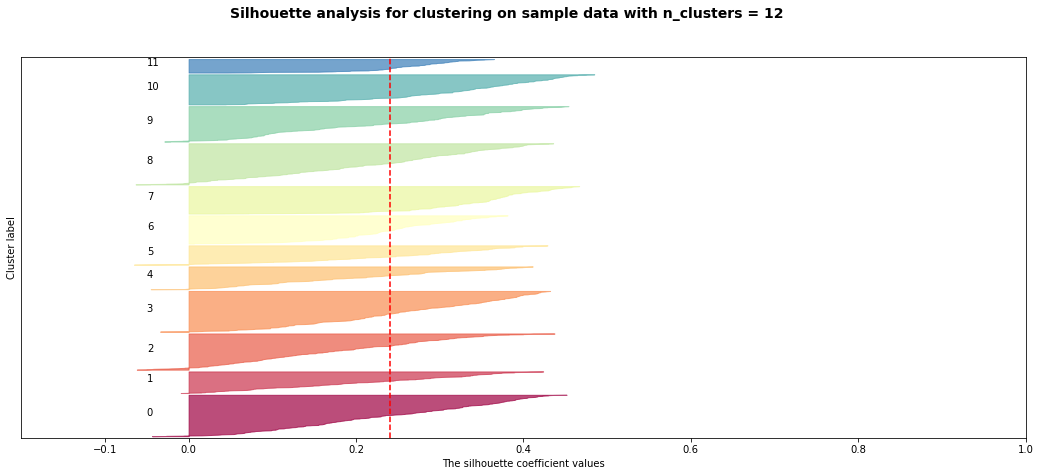

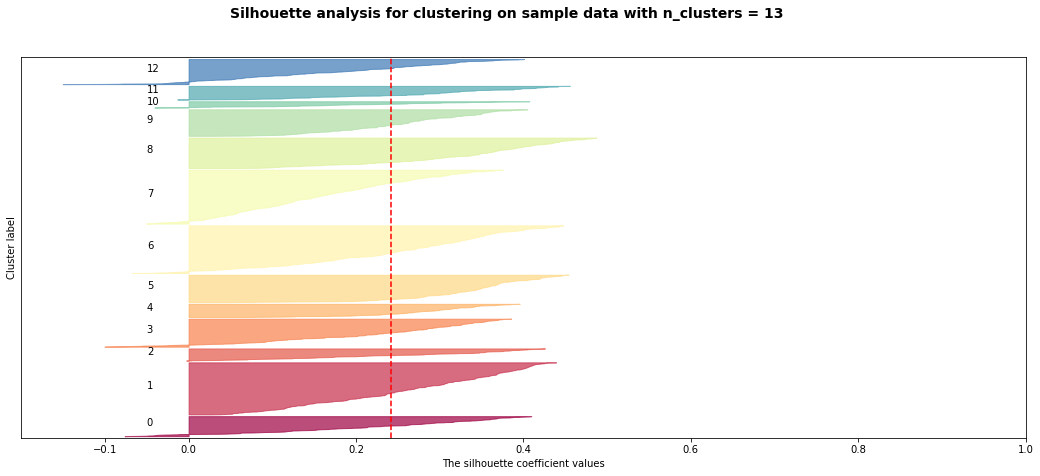

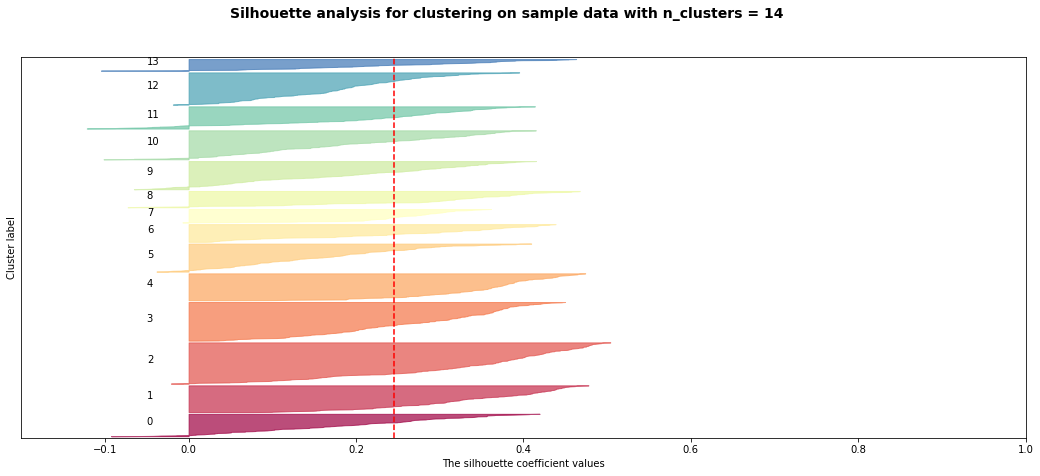

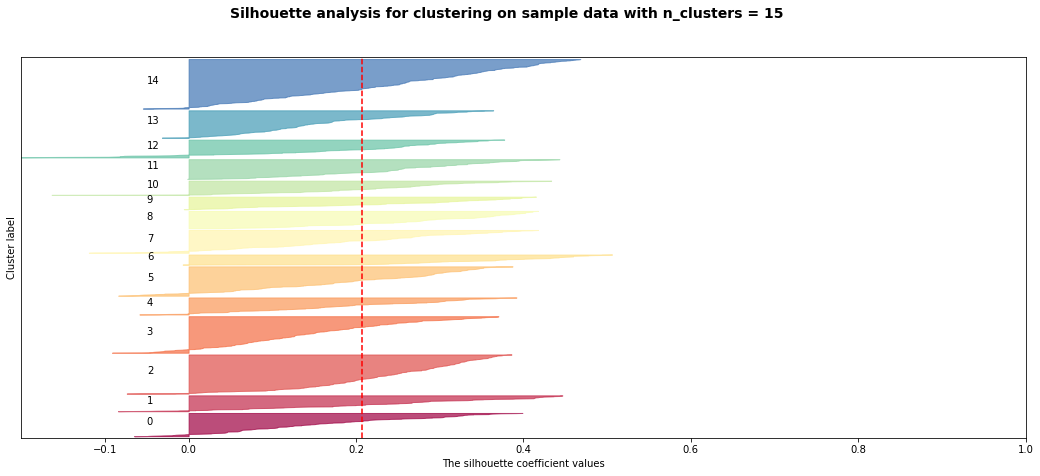

In [184]:
# попробуем пройтись по кол-ву кластеров от 3 до 15, оценивая результат по силуэтам
warnings.filterwarnings('ignore')
for n in range(3,16):
    MBKM = MiniBatchKMeans(n_clusters=n, random_state=1)
    sil_plot(MBKM, scaled_data, n)

In [185]:
# Определенно, разбиение на 4 кластера наилучшее

MBKM = MiniBatchKMeans(n_clusters=6, random_state=1)
resultMBKM = MBKM.fit_predict(scaled_data)
# кол-во пользователей в каждом кластере при разбиении на 4 кластера
np.unique(resultMBKM, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([245, 361, 252, 443, 593, 321], dtype=int64))

In [186]:
print("в первом сегменте средние затраты: {:.0f}".format(data_a.loc[scaled_data.index[resultMBKM == 0]].Spending.mean()))
print("во втором сегменте средние затраты: {:.0f}".format(data_a.loc[scaled_data.index[resultMBKM == 1]].Spending.mean()))
print("в третьем сегменте средние затраты: {:.0f}".format(data_a.loc[scaled_data.index[resultMBKM == 2]].Spending.mean()))
print("в четвертом сегменте средние затраты: {:.0f}".format(data_a.loc[scaled_data.index[resultMBKM == 3]].Spending.mean()))

в первом сегменте средние затраты: 1328
во втором сегменте средние затраты: 1265
в третьем сегменте средние затраты: 397
в четвертом сегменте средние затраты: 609


In [ ]:
# Первый и второй сегменты представляют наибольший интерес, поскольку средние затраты покупателей значительно выше, чем в других

###### 2.5 Метод Affinity Propagation

In [198]:
# данный подход не требует заранее определять число кластеров, он определяет их сам
AFP = AffinityPropagation(random_state=1).fit(scaled_data)
np.sort(AFP.labels_)

array([ 0,  0,  0, ..., 85, 85, 85], dtype=int64)

For n_clusters = 86 The average silhouette_score is :0.237


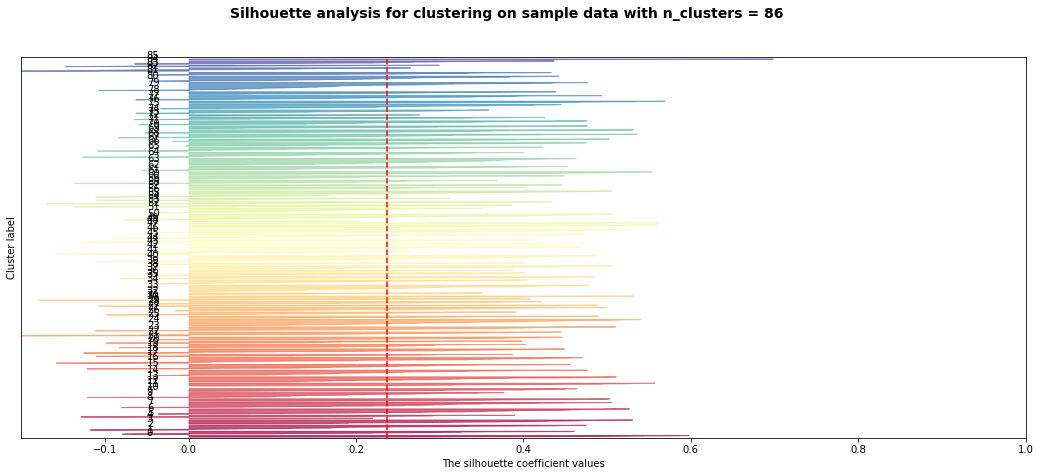

In [188]:
sil_plot(AFP, scaled_data, len(set(AFP.labels_)))

In [ ]:
# Этот результат, конечно, никуда не годится

##### 2.6 Метод Агломеративной иерархической кластеризации

In [193]:
from sklearn.cluster import AgglomerativeClustering

For n_clusters = 3 The average silhouette_score is :0.223
For n_clusters = 4 The average silhouette_score is :0.286
For n_clusters = 5 The average silhouette_score is :0.244
For n_clusters = 6 The average silhouette_score is :0.272
For n_clusters = 7 The average silhouette_score is :0.272
For n_clusters = 8 The average silhouette_score is :0.273
For n_clusters = 9 The average silhouette_score is :0.236
For n_clusters = 10 The average silhouette_score is :0.237
For n_clusters = 11 The average silhouette_score is :0.244
For n_clusters = 12 The average silhouette_score is :0.242
For n_clusters = 13 The average silhouette_score is :0.243
For n_clusters = 14 The average silhouette_score is :0.234
For n_clusters = 15 The average silhouette_score is :0.233


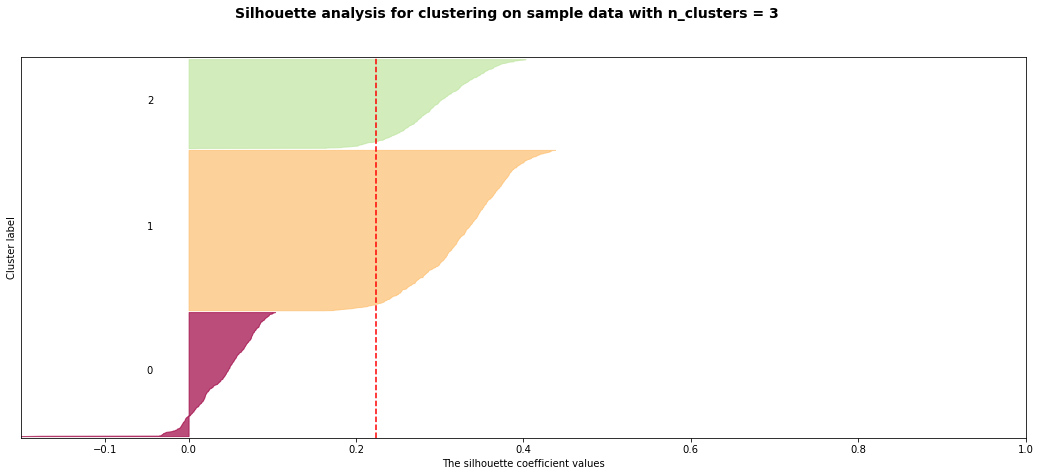

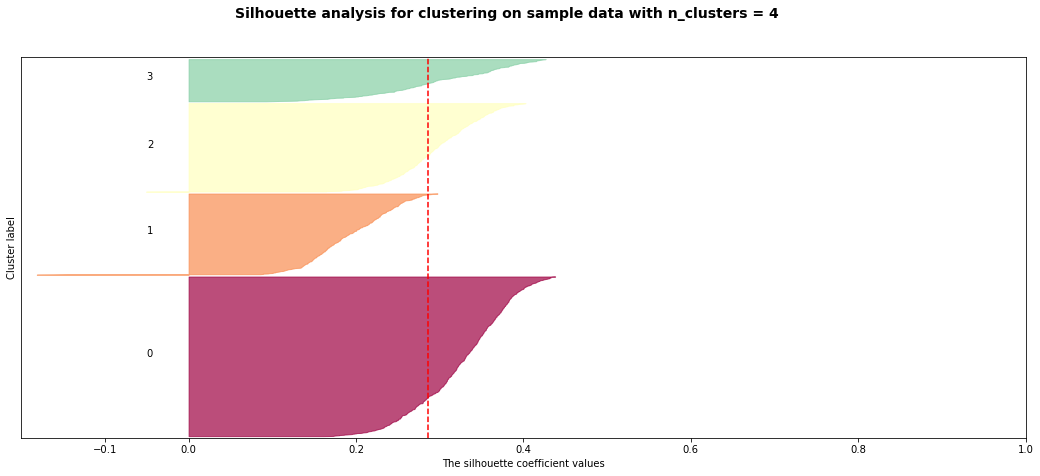

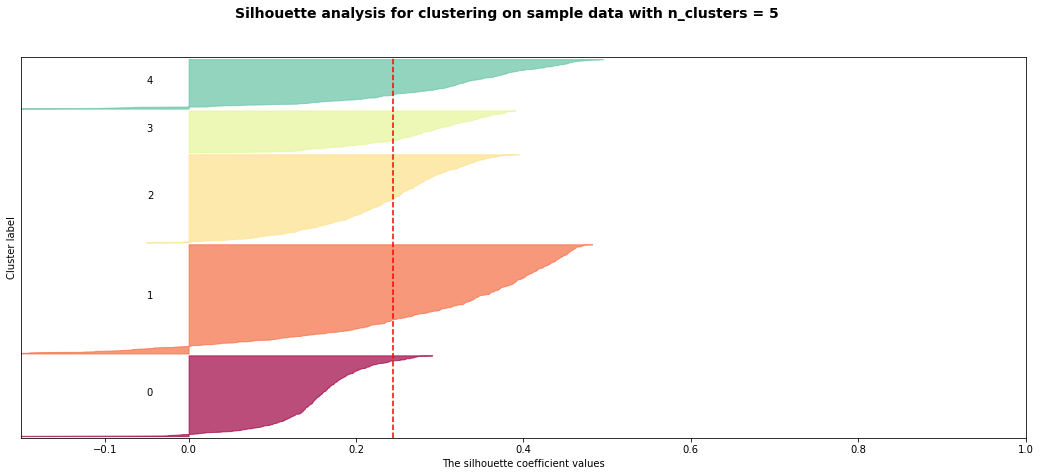

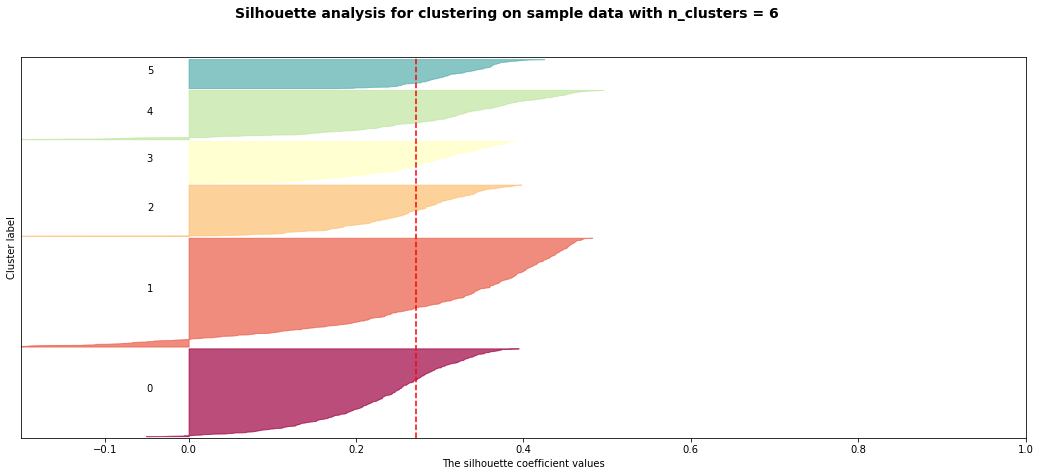

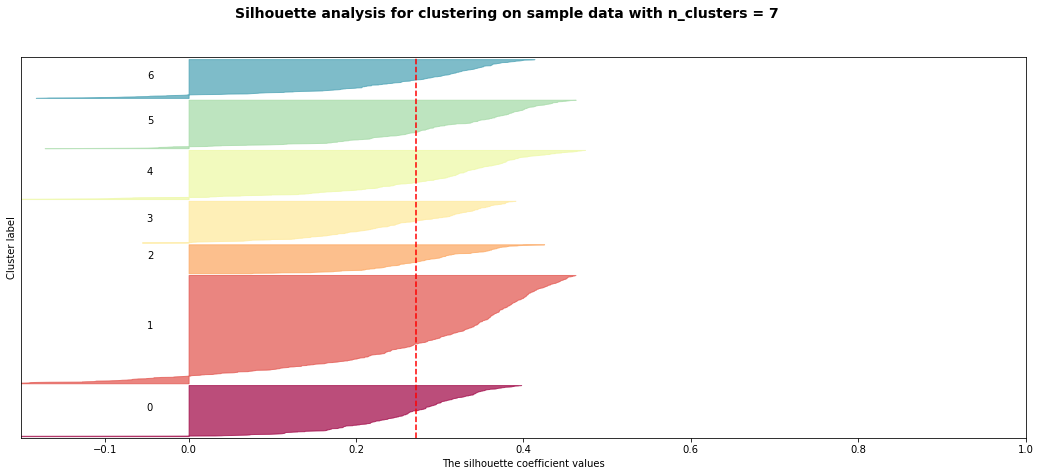

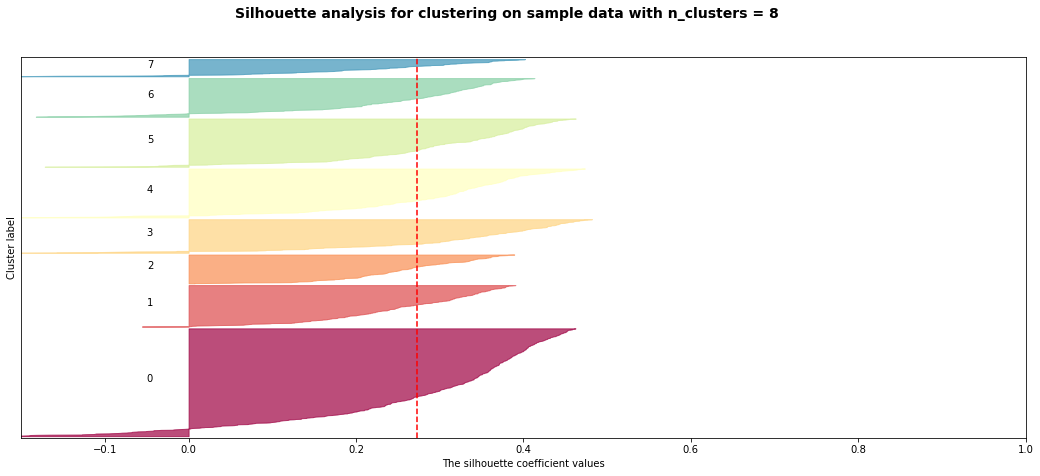

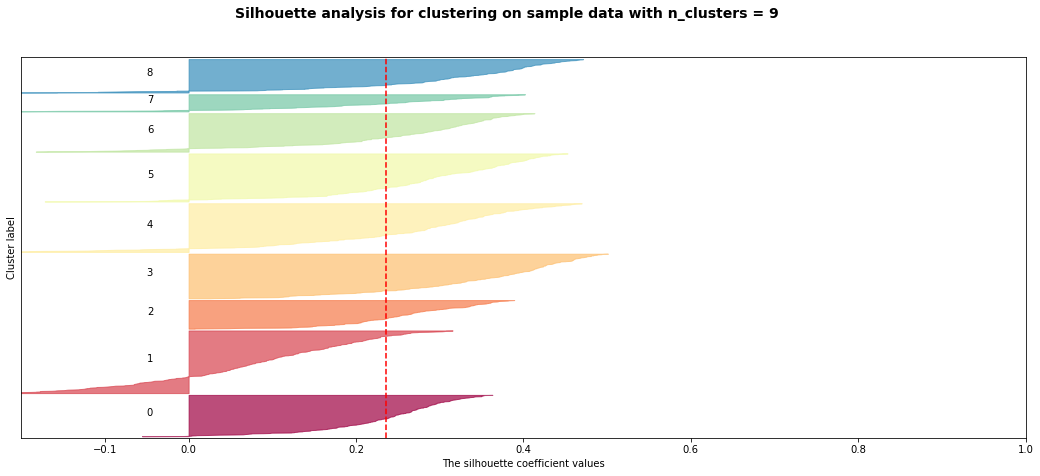

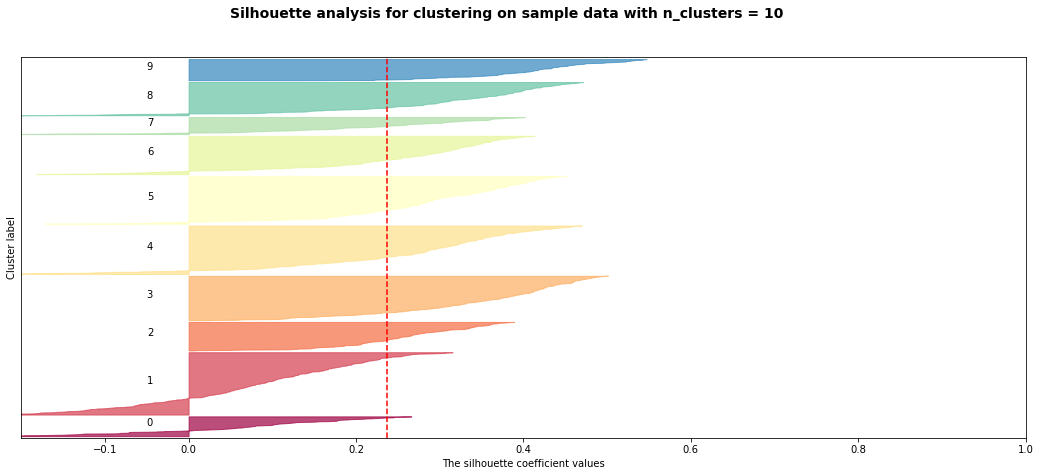

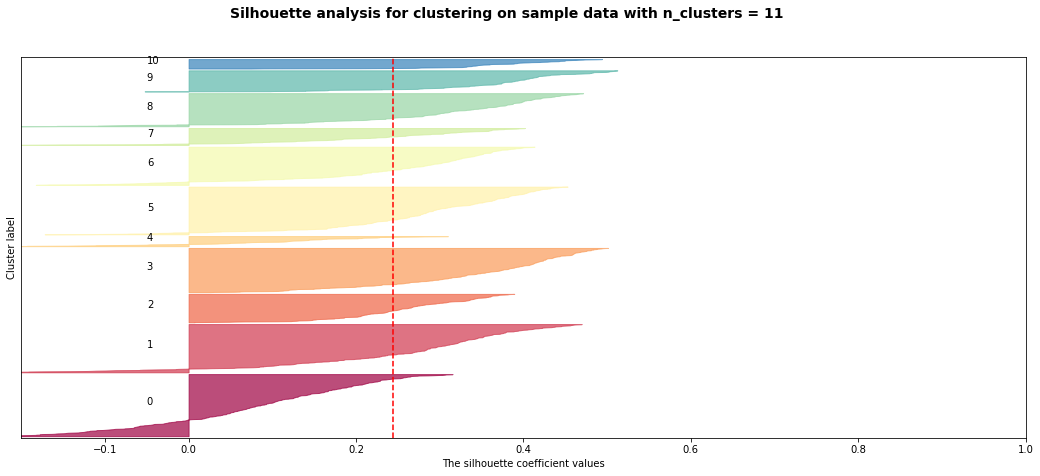

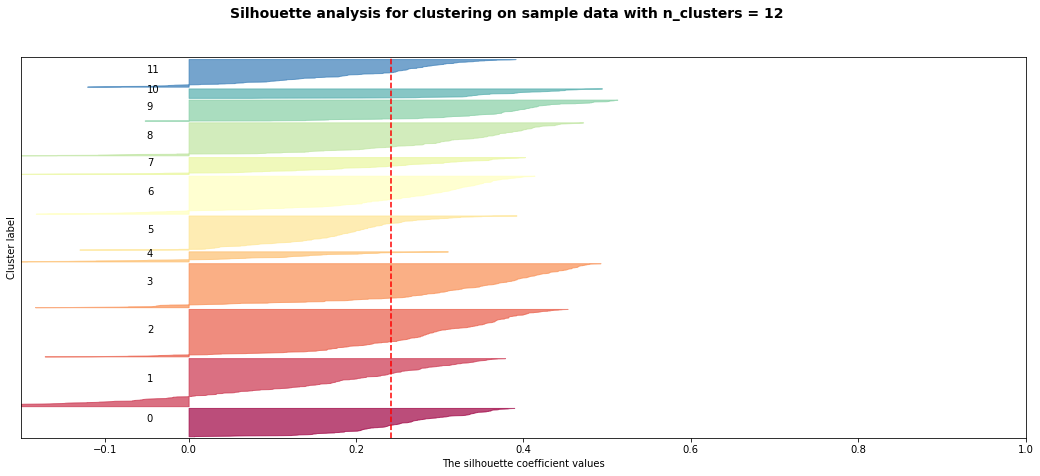

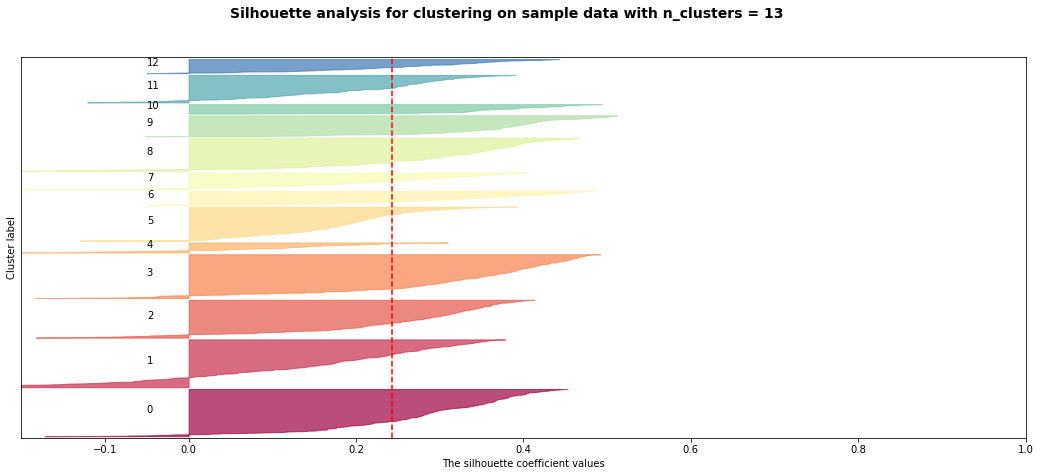

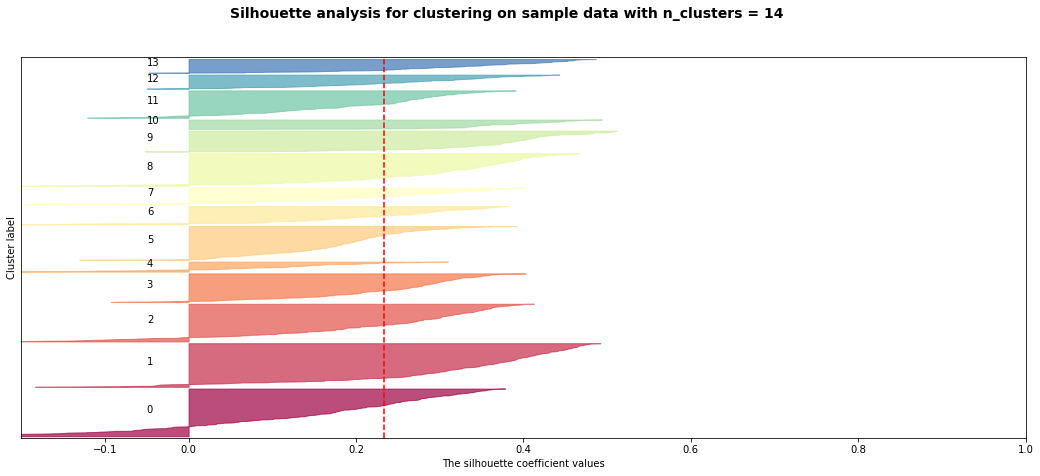

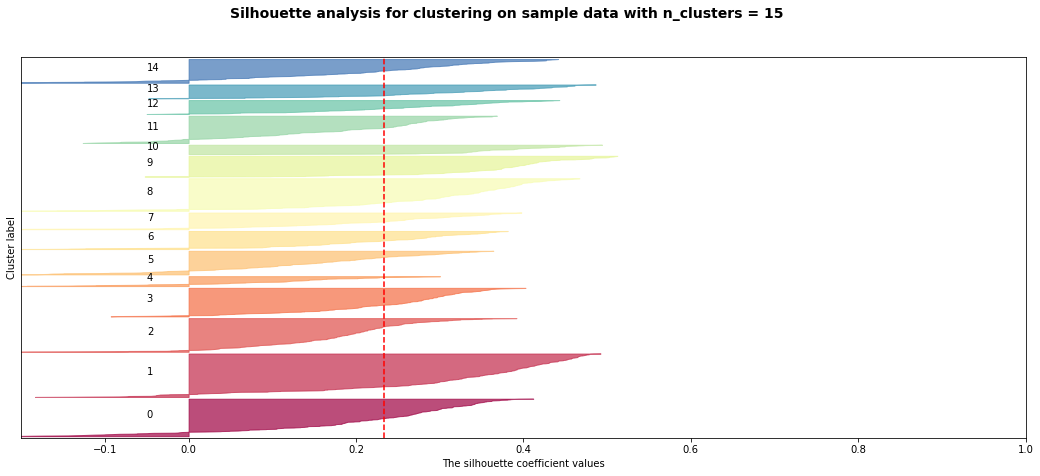

In [199]:
# попробуем пройтись по кол-ву кластеров от 3 до 15, оценивая результат по силуэтам
for n in range(3,16): 
    AMC = AgglomerativeClustering(n_clusters=n)
    sil_plot(AMC, scaled_data, n)

In [ ]:
# Более-менее разбиение на 4 сегмента, но результат визуально хуже, чем в K-Means